# Mise en oeuvre technique de la simulation : les effets financiers de la tarification solidaire du côté des individus et du côté de la collectivité 

La modélisation se fait par un principe qui se nomme la micro-simulation. À la différence de méthodes habituelles de modélisation, la micro-simulation permet de passer d'une modélisation par hypothèses à une modélisation par généralisation de cas réels . 
Ainsi les hypothèses qui portent habituellement sur les caractéristiques du public concerné, sont remplacées par des données sur le nombre réel de ménages par tranche de QF. 
Ces principes de micro-simulation sont utilisés par l'INSEE, la CNAF ou le Ministère du Budget. 
L'avantage de cette approche est aussi de combiner cette modélisation avec les modélisations des autres tarifs payants de la collectivité ou/et avec la modélisation des minima sociaux telle qu'elle est réalisée par mes-aides.org. 
Ceci permet d'estimer finement le coût d'un panier de services pour une famille selon sa tranche de QF. 

In [1]:
import pandas as pd
import numpy as np

1ère base de données : QF CAF et nombre de repas pris pour chaque enfant

In [169]:
df = pd.read_csv('./Bilan tarification 2019.csv', sep=";", encoding="iso-8859-1")
df

,Id Personne,Id Famille,QF,Type repas,Nombre,id gale ou non,type de repas simplifi par tarif identique
0,1,325,999999,Repas Végétarien,2,NaN,Repas vgtarien
1,2,497,636,Repas Standard,1,NaN,Repas Standard
2,3,762,999999,Repas Standard,1,NaN,Repas Standard
3,4,770,392,Repas Standard,125,oui,Repas Standard
4,4,770,999999,Repas Standard,1,NaN,Repas Standard
...,...,...,...,...,...,...,...
16930,15579,10849,999999,Repas Sans Porc,8,NaN,Repas Standard
16931,15580,10850,999999,Repas Standard,13,NaN,Repas Standard
16932,15581,10851,259,Repas Standard,12,NaN,Repas Standard
16933,15582,10852,620,Repas Standard,14,NaN,Repas Standard


2ème base de données avec des profils types : dans cette base de données il y a le QF CAF et le QF EMS pour chaque cas et avec cette base il est possible de faire des comparaison de tarifs en fonction des différents scénarios 

In [3]:
df = pd.read_csv('./données QF CAF-QF EMS.csv', sep=";", encoding="iso-8859-1")
df

,Id Personne,Id Famille,QF CAF,QF EMS,Type repas,Nombre
0,1,1,426,0,Repas Standard,20
1,2,2,689,326,Repas Vgtarien,20
2,3,3,300,0,Repas Standard,20
3,4,4,347,0,Repas Standard,20
4,5,5,445,140,Repas Standard,20
5,6,6,485,0,Repas Standard,20
6,7,7,121,0,Repas Standard,20
7,8,8,388,176,Repas Standard,20
8,9,9,496,596,Repas Standard,20
9,10,10,332,0,Repas Vgtarien,20


In [4]:
df['QF'] = df['QF CAF'] # dans ce tableau le QF est égale au QF CAF 
df

,Id Personne,Id Famille,QF CAF,QF EMS,Type repas,Nombre,QF
0,1,1,426,0,Repas Standard,20,426
1,2,2,689,326,Repas Vgtarien,20,689
2,3,3,300,0,Repas Standard,20,300
3,4,4,347,0,Repas Standard,20,347
4,5,5,445,140,Repas Standard,20,445
5,6,6,485,0,Repas Standard,20,485
6,7,7,121,0,Repas Standard,20,121
7,8,8,388,176,Repas Standard,20,388
8,9,9,496,596,Repas Standard,20,496
9,10,10,332,0,Repas Vgtarien,20,332


In [5]:
df['QF'] = df['QF EMS'] # dans ce tableau le QF est égale au QF EMS 
df

,Id Personne,Id Famille,QF CAF,QF EMS,Type repas,Nombre,QF
0,1,1,426,0,Repas Standard,20,0
1,2,2,689,326,Repas Vgtarien,20,326
2,3,3,300,0,Repas Standard,20,0
3,4,4,347,0,Repas Standard,20,0
4,5,5,445,140,Repas Standard,20,140
5,6,6,485,0,Repas Standard,20,0
6,7,7,121,0,Repas Standard,20,0
7,8,8,388,176,Repas Standard,20,176
8,9,9,496,596,Repas Standard,20,596
9,10,10,332,0,Repas Vgtarien,20,0


In [6]:
df['QF EMS'] - df['QF CAF'] # Variation entre QF CAF et QF EMS 

0    -426
1    -363
2    -300
3    -347
4    -305
5    -485
6    -121
7    -212
8     100
9    -332
10   -204
11   -488
12   -283
13   -101
14   -419
15    245
dtype: int64

In [170]:
df[df['Id Famille'] ==  443] # toutes les familles qui ont un identifiant famille égale à 443

,Id Personne,Id Famille,QF,Type repas,Nombre,id gale ou non,type de repas simplifi par tarif identique
7167,6691,443,379,Repas Sans Porc,62,oui,Repas Standard
7168,6691,443,1030,Repas Halal,41,oui,Repas Standard
7169,6691,443,1030,Repas Sans Porc,14,NaN,Repas Standard


In [171]:
df[['Id Personne', 'Id Famille', 'QF', 'Type repas', 'Nombre']]

,Id Personne,Id Famille,QF,Type repas,Nombre
0,1,325,999999,Repas Végétarien,2
1,2,497,636,Repas Standard,1
2,3,762,999999,Repas Standard,1
3,4,770,392,Repas Standard,125
4,4,770,999999,Repas Standard,1
...,...,...,...,...,...
16930,15579,10849,999999,Repas Sans Porc,8
16931,15580,10850,999999,Repas Standard,13
16932,15581,10851,259,Repas Standard,12
16933,15582,10852,620,Repas Standard,14


In [172]:
df[['Type repas', 'Nombre']].groupby('Type repas').count() # nombre de repas par type de repas 

,Nombre
Type repas,
Panier,112
Repas Halal,5544
Repas Sans Porc,1205
Repas Standard,9118
Repas Végétarien,956


In [173]:
df[['Type repas', 'Nombre']].groupby('Type repas').sum() # somme du nombre de repas par type de repas 

,Nombre
Type repas,
Panier,7380
Repas Halal,433040
Repas Sans Porc,107789
Repas Standard,894000
Repas Végétarien,61394


In [174]:
np.unique(df['Id Famille'])

array([    1,     2,     3, ..., 10850, 10851, 10852])

In [175]:
df['Repas'] = np.select(
    [
        df["Type repas"].str.contains('tarien'), #tarien = végétarien
        df["Type repas"].str.contains('Panier'),
    ],
    [
        'cantine_vegetarien',
        'cantine_panier',
    ],
    default = 'cantine'
)
df

,Id Personne,Id Famille,QF,Type repas,Nombre,id gale ou non,type de repas simplifi par tarif identique,Repas
0,1,325,999999,Repas Végétarien,2,NaN,Repas vgtarien,cantine_vegetarien
1,2,497,636,Repas Standard,1,NaN,Repas Standard,cantine
2,3,762,999999,Repas Standard,1,NaN,Repas Standard,cantine
3,4,770,392,Repas Standard,125,oui,Repas Standard,cantine
4,4,770,999999,Repas Standard,1,NaN,Repas Standard,cantine
...,...,...,...,...,...,...,...,...
16930,15579,10849,999999,Repas Sans Porc,8,NaN,Repas Standard,cantine
16931,15580,10850,999999,Repas Standard,13,NaN,Repas Standard,cantine
16932,15581,10851,259,Repas Standard,12,NaN,Repas Standard,cantine
16933,15582,10852,620,Repas Standard,14,NaN,Repas Standard,cantine


In [176]:
df[['Repas', 'Nombre']] # nombre de repas pour chaque enfant

,Repas,Nombre
0,cantine_vegetarien,2
1,cantine,1
2,cantine,1
3,cantine,125
4,cantine,1
...,...,...
16930,cantine,8
16931,cantine,13
16932,cantine,12
16933,cantine,14


In [177]:
df[['Repas', 'Nombre']].groupby('Repas').count() # 15867 enfants prennent le repas standard (cantine)

,Nombre
Repas,
cantine,15867
cantine_panier,112
cantine_vegetarien,956


In [178]:
df[['Repas', 'Nombre']].groupby('Repas').sum()

,Nombre
Repas,
cantine,1434829
cantine_panier,7380
cantine_vegetarien,61394


In [179]:
import matplotlib.pyplot as plt

Histogramme qui représente le nombre d'enfants pour chaque type de repas 

(array([  956.,     0.,     0.,     0.,     0., 15867.,     0.,     0.,
            0.,   112.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

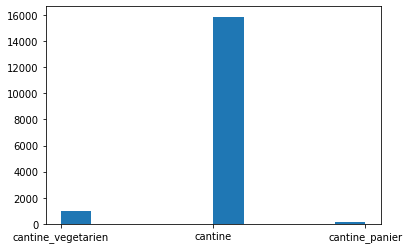

In [180]:
plt.hist(df[['Repas']]) # il y a 15867 enfants qui prennent le repas standard (cantine sur le graphique)

Hisogramme qui représente le nombre de repas en fonction du type de repas 

(array([  61394.,       0.,       0.,       0.,       0., 1434829.,
              0.,       0.,       0.,    7380.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

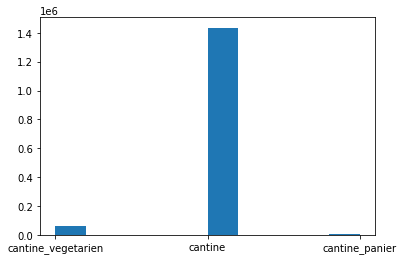

In [181]:
plt.hist(df[['Repas']], weights = df[['Nombre']]) # il y a 1434829 repas standards (cantine) 

In [182]:
df.QF

0        999999
1           636
2        999999
3           392
4        999999
          ...  
16930    999999
16931    999999
16932       259
16933       620
16934       620
Name: QF, Length: 16935, dtype: int64

In [183]:
np.unique(df.QF)

array([     1,      3,     13, ...,  13591,  13939, 999999])

Distribution des QF des familles des enfants qui viennent à la cantine scolaire 

(array([15859.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1076.]),
 array([1.000000e+00, 1.000008e+05, 2.000006e+05, 3.000004e+05,
        4.000002e+05, 5.000000e+05, 5.999998e+05, 6.999996e+05,
        7.999994e+05, 8.999992e+05, 9.999990e+05]),
 <BarContainer object of 10 artists>)

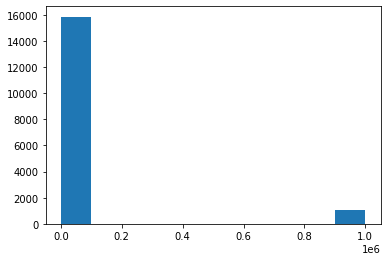

In [184]:
plt.hist(df.QF) 

Histogramme qui représente le nombre de familles en fonction du QF 

(array([7225., 4943., 2032., 1034.,  319.,  135.,   53.,   42.,   24.,
          14.]),
 array([1.000e+00, 5.730e+02, 1.145e+03, 1.717e+03, 2.289e+03, 2.861e+03,
        3.433e+03, 4.005e+03, 4.577e+03, 5.149e+03, 5.721e+03]),
 <BarContainer object of 10 artists>)

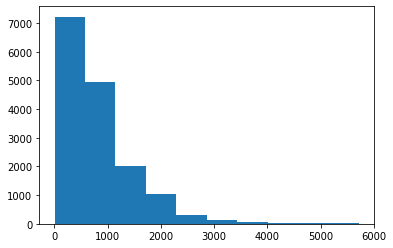

In [185]:
plt.hist(df.QF[df.QF< 6000])

Histogramme cumulé : Distribution des familles en fonction des QF

(array([0.03842993, 0.04108463, 0.0523355 , 0.06150054, 0.10309083,
        0.16528664, 0.2526389 , 0.33632514, 0.40117565, 0.45667151,
        0.51400038, 0.5717717 , 0.61873459, 0.65267682, 0.67846533,
        0.700335  , 0.71853865, 0.73699513, 0.75210164, 0.76910435,
        0.7845901 , 0.80190886, 0.81701536, 0.82940396, 0.84141331,
        0.85582454, 0.86796031, 0.87978004, 0.88730169, 0.89754124,
        0.90803363, 0.91637697, 0.92440427, 0.93116744, 0.93856267,
        0.94374565, 0.94918147, 0.95423804, 0.95916819, 0.96289741,
        0.9654257 , 0.96763795, 0.97029265, 0.9725049 , 0.97433791,
        0.97636053, 0.97850958, 0.98034258, 0.98173314, 0.98306049,
        0.9840086 , 0.98476708, 0.98558877, 0.98660009, 0.98729537,
        0.9884331 , 0.98957082, 0.99039252, 0.99102459, 0.99159345,
        0.99178307, 0.99241514, 0.99279439, 0.99298401, 0.99330004,
        0.99355287, 0.99393212, 0.99462739, 0.99481702, 0.99494343,
        0.99532267, 0.99563871, 0.99582833, 0.99

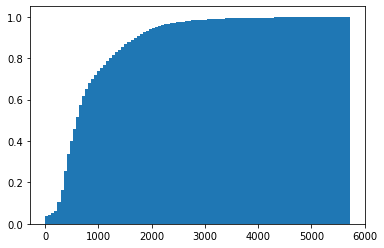

In [186]:
plt.hist(df.QF[df.QF< 6000], density=True, bins=100, cumulative=True) # 0,05% des familles ont un QF de 0€

(array([0.04195181, 0.04483239, 0.05696095, 0.06635117, 0.11023017,
        0.17319098, 0.26119613, 0.34131084, 0.40099958, 0.45050525,
        0.50212118, 0.55444405, 0.59858076, 0.62947217, 0.65441371,
        0.67424118, 0.69188164, 0.70861448, 0.72304343, 0.74127747,
        0.75697102, 0.77477765, 0.79041699, 0.80376088, 0.81713081,
        0.83317361, 0.84699701, 0.85961001, 0.86758072, 0.8792178 ,
        0.89129356, 0.90119216, 0.91018384, 0.91790387, 0.92576755,
        0.93119425, 0.93778416, 0.94408186, 0.95019367, 0.95480147,
        0.9579137 , 0.96056403, 0.96385512, 0.96653995, 0.96881427,
        0.97131814, 0.97371006, 0.97601889, 0.97767288, 0.97913253,
        0.98029293, 0.98133433, 0.98234334, 0.98355937, 0.98442333,
        0.985971  , 0.98736306, 0.98836573, 0.98905859, 0.98981905,
        0.99007957, 0.99089777, 0.99141882, 0.99150965, 0.99188495,
        0.9922511 , 0.99281862, 0.99358542, 0.99384031, 0.99392832,
        0.99439375, 0.9948634 , 0.99513942, 0.99

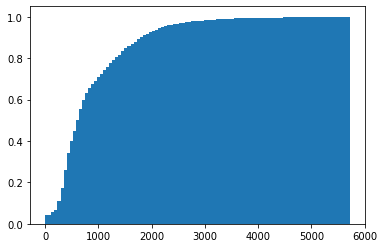

In [188]:
plt.hist(df.QF[df.QF< 6000], density=True, bins=100, cumulative=True, weights=df.Nombre[df.QF< 6000]) # 0,05% des repas sont pris par des familles qui ont un QF de 0€

(array([1.40234262e-03, 6.45038214e-05, 5.05197868e-05, 5.01997297e-05,
        2.18131243e-04, 2.05944453e-04, 1.75785223e-04, 1.52544152e-04,
        7.36623792e-04, 7.97606985e-04, 9.09873178e-04, 1.29155361e-03,
        1.28948555e-03, 1.78761754e-03, 1.46770813e-03, 1.33350572e-03,
        1.26230532e-03, 8.24713362e-04, 9.02388765e-04, 8.28578667e-04,
        8.70727729e-04, 9.34025181e-04, 9.10242475e-04, 9.19228694e-04,
        9.49338684e-04, 5.93902932e-04, 5.73173078e-04, 5.06945872e-04,
        4.75383316e-04, 3.96698501e-04, 3.58390125e-04, 3.34878236e-04,
        3.14517679e-04, 3.02281648e-04, 2.97751609e-04, 2.87312823e-04,
        2.23719933e-04, 2.80788581e-04, 3.74368362e-04, 2.63185439e-04,
        2.65598177e-04, 2.83127460e-04, 3.17595151e-04, 3.05014444e-04,
        2.65967474e-04, 2.80862441e-04, 2.57892187e-04, 2.08677248e-04,
        2.16260140e-04, 2.51220226e-04, 2.67838577e-04, 2.93098471e-04,
        2.41027638e-04, 2.42307866e-04, 2.17663467e-04, 2.233506

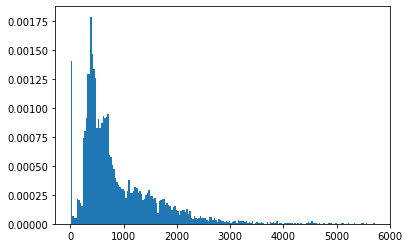

In [189]:
plt.hist(df.QF[df.QF< 6000], density=True, bins=200, weights=df.Nombre[df.QF< 6000])

(array([ 639808., 1052763., 1248666., 1356010., 1390565., 1405742.,
        1411578., 1416325., 1418723., 1420201.]),
 array([1.000e+00, 5.730e+02, 1.145e+03, 1.717e+03, 2.289e+03, 2.861e+03,
        3.433e+03, 4.005e+03, 4.577e+03, 5.149e+03, 5.721e+03]),
 <BarContainer object of 10 artists>)

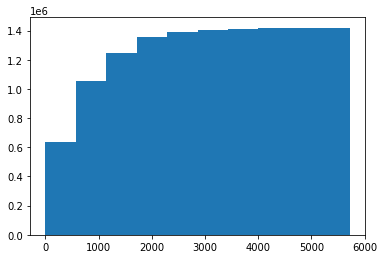

In [190]:
plt.hist(df.QF[df.QF< 6000], cumulative=True, weights=df.Nombre[df.QF< 6000]) # 639808 repas sont pris par des familles qui ont un QF de 0€

(array([392203., 181223., 846775.]),
 array([   0,  410,  520, 6000]),
 <BarContainer object of 3 artists>)

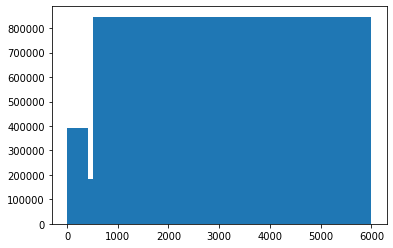

In [191]:
plt.hist(df.QF[df.QF< 6000], bins=[0, 410, 520, 6000], weights=df.Nombre[df.QF< 6000]) # 392203 repas sont pris par des familles qui ont un QF entre 0 et 410€

Le nombre de repas pris en fonction du QF pour la tranche de QF de 0 à 410€

(array([55371.,     0.,   132.,     0.,   125.,   264.,  1068.,   256.,
          270.,   822.,  1017.,    69.,     0.,   186.,   134.,   408.,
          332.,   305.,   338.,   264.,   271.,     0.,     0.,   271.,
          404.,   550.,   376.,   438.,   279.,  2083.,  1960.,   480.,
         1167.,  1585.,  1306.,  1206.,   803.,   949.,   770.,  2156.,
         1153.,  1328.,  1904.,  1065.,   272.,  1019.,  1157.,   966.,
          664.,   837.,   878.,   572.,   280.,   756.,  2287.,   679.,
         2879.,  2488.,  2226.,  6213.,  3526.,  4618.,  7970.,  3535.,
         5835.,  2747.,  5495.,  4907.,  4665.,  5213.,  7782.,  4695.,
         3773.,  5213.,  5710.,  5360.,  4424.,  8054.,  5666.,  5478.,
         8269.,  9435.,  6166.,  8114.,  7480.,  8990.,  7955., 10246.,
         7713.,  5624.,  5646.,  7087., 10058.,  9568.,  9705., 10720.,
        11110., 11966., 12307., 11340.]),
 array([  1.  ,   5.08,   9.16,  13.24,  17.32,  21.4 ,  25.48,  29.56,
         33.64,  37.72

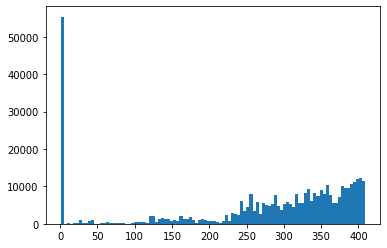

In [192]:
inf, sup = (0, 410)
cond = (inf < df.QF) & (df.QF < sup)
plt.hist(df.QF[cond], bins=100, weights=df.Nombre[cond]) # 55371 repas sont pris pour la tranche de QF de 0 à 410€

(array([22391., 22212., 21831., 16958., 16586., 20921., 19304., 12511.,
        14359., 11586.]),
 array([411. , 421.8, 432.6, 443.4, 454.2, 465. , 475.8, 486.6, 497.4,
        508.2, 519. ]),
 <BarContainer object of 10 artists>)

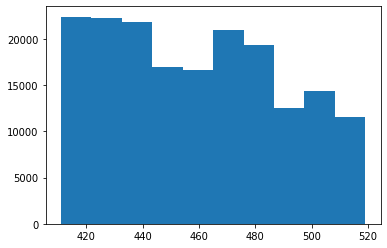

In [193]:
inf, sup = (410, 520)
cond = (inf < df.QF) & (df.QF < sup)
plt.hist(df.QF[cond], bins=10, weights=df.Nombre[cond])

(array([22391., 22212., 21831., 16958., 16586., 20921., 19304., 12511.,
        14359., 11586.]),
 array([411. , 421.8, 432.6, 443.4, 454.2, 465. , 475.8, 486.6, 497.4,
        508.2, 519. ]),
 <BarContainer object of 10 artists>)

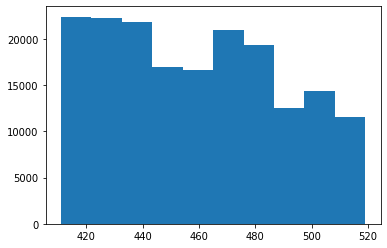

In [194]:
inf, sup = (410, 520)
cond = (inf < df.QF) & (df.QF < sup)
plt.hist(df.QF[cond], bins=10, weights=df.Nombre[cond])

In [195]:
df[df['Id Famille'] == 443]

,Id Personne,Id Famille,QF,Type repas,Nombre,id gale ou non,type de repas simplifi par tarif identique,Repas
7167,6691,443,379,Repas Sans Porc,62,oui,Repas Standard,cantine
7168,6691,443,1030,Repas Halal,41,oui,Repas Standard,cantine
7169,6691,443,1030,Repas Sans Porc,14,NaN,Repas Standard,cantine


In [196]:
df.QF = np.minimum(df.QF, 99999)

In [197]:
bogus_raw_df = pd.pivot_table(df, index=["Id Personne", "Id Famille", "QF"], columns="Repas", values="Nombre", fill_value=0)
bogus_raw_df

Repas                         cantine  cantine_panier  cantine_vegetarien
Id Personne Id Famille QF                                                
1           325        99999      0.0               0                   2
2           497        636        1.0               0                   0
3           762        99999      1.0               0                   0
4           770        392      125.0               0                   0
                       99999      1.0               0                   0
...                               ...             ...                 ...
15579       10849      99999      8.0               0                   0
15580       10850      99999     13.0               0                   0
15581       10851      259       12.0               0                   0
15582       10852      620       14.0               0                   0
15583       10852      620       10.0               0                   0

[16657 rows x 3 columns]

In [198]:
raw_df = pd.pivot_table(df, index=["Id Personne", "Id Famille", "QF"], columns="Repas", values="Nombre", fill_value=0, aggfunc=np.sum)
#raw_df[fix_raw_df.index == (6691, 443, 1030)]

In [199]:
raw_df[raw_df.index == (6691, 443, 1030)]

,,Repas,cantine,cantine_panier,cantine_vegetarien
Id Personne,Id Famille,QF,,,


In [200]:
flat_df = raw_df.reset_index()
flat_df

Repas,Id Personne,Id Famille,QF,cantine,cantine_panier,cantine_vegetarien
0,1,325,99999,0,0,2
1,2,497,636,1,0,0
2,3,762,99999,1,0,0
3,4,770,392,125,0,0
4,4,770,99999,1,0,0
...,...,...,...,...,...,...
16652,15579,10849,99999,8,0,0
16653,15580,10850,99999,13,0,0
16654,15581,10851,259,12,0,0
16655,15582,10852,620,14,0,0


In [201]:
flat_df[flat_df['Id Famille'] == 443]

Repas,Id Personne,Id Famille,QF,cantine,cantine_panier,cantine_vegetarien
7057,6691,443,379,62,0,0
7058,6691,443,1030,55,0,0


In [202]:
familles_ids = flat_df["Id Famille"] * 100000 + flat_df.QF
familles_ids

0          32599999
1          49700636
2          76299999
3          77000392
4          77099999
            ...    
16652    1084999999
16653    1085099999
16654    1085100259
16655    1085200620
16656    1085200620
Length: 16657, dtype: int64

In [203]:
(unique_famille_ids, famille_idx, famille_id_inv) = np.unique(familles_ids, return_index=True, return_inverse=True)
unique_famille_ids, famille_idx, famille_id_inv

(array([    100301,     200455,     300601, ..., 1085099999, 1085100259,
        1085200620], dtype=int64),
 array([14700,  4244,  3271, ..., 16653, 16654, 16655]),
 array([  334,   514,   786, ..., 11608, 11609, 11609]))

In [204]:
unique_famille_ids

array([    100301,     200455,     300601, ..., 1085099999, 1085100259,
       1085200620], dtype=int64)

In [205]:
len(famille_id_inv)

16657

In [206]:
len(famille_idx)

11610

In [207]:
famille_idx[famille_id_inv]

array([    0,     1,     2, ..., 16654, 16655, 16655])

In [208]:
unique_famille_ids

array([    100301,     200455,     300601, ..., 1085099999, 1085100259,
       1085200620], dtype=int64)

In [209]:
len(unique_famille_ids)

11610

In [210]:
famille_id_inv

array([  334,   514,   786, ..., 11608, 11609, 11609])

In [211]:
individu_df = pd.DataFrame({
    'famille_id': famille_id_inv,
    'strasbourg_metropole_nombre_repas_cantine':flat_df.cantine,
    'strasbourg_metropole_nombre_repas_cantine_vegetarien':flat_df.cantine_vegetarien,
    'strasbourg_metropole_nombre_repas_cantine_panier':flat_df.cantine_panier,
})
individu_df # nombre de repas pour chaque enfant selon le type de repas 

,famille_id,strasbourg_metropole_nombre_repas_cantine,strasbourg_metropole_nombre_repas_cantine_vegetarien,strasbourg_metropole_nombre_repas_cantine_panier
0,334,0,2,0
1,514,1,0,0
2,786,1,0,0
3,794,125,0,0
4,795,1,0,0
...,...,...,...,...
16652,11606,8,0,0
16653,11607,13,0,0
16654,11608,12,0,0
16655,11609,14,0,0


In [212]:
famille_idx

array([14700,  4244,  3271, ..., 16653, 16654, 16655])

In [213]:
famille_df = pd.DataFrame({
    'strasbourg_metropole_quotient_familial': flat_df.QF[famille_idx]
})
famille_df

,strasbourg_metropole_quotient_familial
14700,301
4244,455
3271,601
2796,787
12016,244
...,...
16651,99999
7453,99999
16653,99999
16654,259


In [214]:
base_year = "2021-03"

In [215]:
from openfisca_survey_manager.scenarios import AbstractSurveyScenario
from openfisca_france import CountryTaxBenefitSystem
from openfisca_france.model.base import Famille, FoyerFiscal, Menage
from openfisca_core import periods
from openfisca_core.model_api import Reform

Modélisation des différents scénarios 

In [217]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    return parameters
    
class reform_fusion_1_3(Reform):
    name = u"Fusionne les trois premières tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [218]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.15)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 2.70)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 3.25)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 3.80)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 4.40)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 5.10)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 5.80)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 1.80)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 2.35)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 2.90)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 3.45)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 4.05)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 4.75)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 5.45)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.08)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.35)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 1.63)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 1.90)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 2.20)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 2.55)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 2.90)
    return parameters
    
class reform_fusion_1_5(Reform):
    name = u"Scénario A : Fusionne les trois premières tranches + Hausse du prix différenciée selon les tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [219]:
class StrasbourgSurveyScenario(AbstractSurveyScenario):
    def __init__(self, data = None, reform = None):
        super(StrasbourgSurveyScenario, self).__init__()

        base = CountryTaxBenefitSystem()
        base.load_extension('openfisca_france_local')
        if reform is not None:
            tax_benefit_system = reform(base)
        else:
            tax_benefit_system = base
        self.year = base_year

        if 'input_data_frame_by_entity_by_period' in data:
            period = periods.period(self.year)
            dataframe_variables = set()
            for entity_dataframe in data['input_data_frame_by_entity_by_period'][period].values():
                if not isinstance(entity_dataframe, pd.DataFrame):
                    continue
                dataframe_variables = dataframe_variables.union(set(entity_dataframe.columns))
            self.used_as_input_variables = list(
                set(tax_benefit_system.variables.keys()).intersection(dataframe_variables)
                )

        self.set_tax_benefit_systems(tax_benefit_system)
        self.init_from_data(data = data)

In [220]:
individu_df['famille_role_index'] = 0
individu_df['foyer_fiscal_id'] = individu_df.famille_id
individu_df['foyer_fiscal_role_index'] = 0
individu_df['menage_id'] = individu_df.famille_id
individu_df['menage_role_index'] = 0

In [221]:
menage_df = pd.DataFrame({})
foyerfiscaux_df = pd.DataFrame({})

In [222]:
periods.period(base_year)

Period(('month', Instant((2021, 3, 1)), 1))

In [223]:
data = dict(input_data_frame_by_entity_by_period = {periods.period(base_year): dict(
individu=individu_df,
famille=famille_df,
menage=menage_df,
foyer_fiscal=foyerfiscaux_df)})

In [224]:
def compute_result(data, reform):
    scenario = StrasbourgSurveyScenario(data = data, reform = reform)
    cout_cantine = scenario.simulation.calculate('strasbourg_metropole_cout_cantine', period = '2021-03')
    cout_cantine_vege = scenario.simulation.calculate('strasbourg_metropole_cout_cantine_repas_vegetarien', period = '2021-03')
    cout_cantine_panier = scenario.simulation.calculate('strasbourg_metropole_cout_cantine_repas_panier', period = '2021-03')
    aide_etat = scenario.simulation.calculate('strasbourg_metropole_aide_repas_etat', period = '2021-03')
    return (scenario, np.array([sum(cout_cantine), sum(cout_cantine_vege), sum(cout_cantine_panier)]), np.array([sum(aide_etat)]))

In [225]:
base = compute_result(data, None)

In [226]:
base # somme du nombre de repas en fonction du type de repas 

(<__main__.StrasbourgSurveyScenario at 0x1306c2a10>,
 array([5413949.4430635 ,  187197.99897647,   14112.25020409]),
 array([2508.]))

In [227]:
sum(base[1]) # somme des repas pris 

5615259.692244053

In [228]:
base[2]

array([2508.])

In [229]:
fusion = compute_result(data, reform_fusion_1_3)

In [230]:
base[0]

In [231]:
base[1]

array([5413949.4430635 ,  187197.99897647,   14112.25020409])

In [232]:
fusion # somme des repas en fonction du type de repas 

(<__main__.StrasbourgSurveyScenario at 0x132fa4c50>,
 array([4225744.40664268,  142659.79872477,   10543.20009494]),
 array([6320.]))

In [233]:
fusion[1] - base[1] #différence entre les tarifs de la grille de référence et les tarifs après modification 

array([-1188205.03642082,   -44538.2002517 ,    -3569.05010915])

In [234]:
sum(fusion[1] - base[1])

-1236312.2867816687

In [235]:
sum(fusion[1])

4378947.405462384

In [236]:
base[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [237]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.15
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.7
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.25
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 3.8
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 4.4
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 5.1
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 5.8
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [238]:
fusion = compute_result(data, reform_fusion_1_5) # Scénario A 

In [239]:
fusion # somme des repas en fonction du type de repas pour le scénario A

(<__main__.StrasbourgSurveyScenario at 0x135823a90>,
 array([4225744.40664268,  142659.79872477,   10543.20009494]),
 array([6320.]))

In [240]:
fusion[1]

array([4225744.40664268,  142659.79872477,   10543.20009494])

In [241]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine # tarifs pour le scénario A pour le repas standard

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.15
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.7
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.25
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 3.8
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 4.4
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 5.1
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 5.8
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [242]:
fusion = compute_result(data, reform_fusion_1_5)

In [243]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege # tarifs pour le scénario A pour le repas végétarien

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.15
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.8
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.35
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.9
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 3.45
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 4.05
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 4.75
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 5.45
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [244]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier # tarifs pour le scénario A pour le panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.08
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.35
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 1.63
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 1.9
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 2.2
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 2.55
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 2.9
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [245]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.00)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 2.50)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 3.00)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 4.50)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 6.00)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.50)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 9.00)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 1.65)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 2.15)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 2.65)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 4.15)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.65)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 7.15)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 8.65)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.25)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.25)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 3.00)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.75)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.50)
    return parameters
    
class reform_fusion_1_6(Reform):
    name = u"Scénario B : Fusionne les trois premières tranches + Hausse du prix"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [246]:
fusion = compute_result(data, reform_fusion_1_6)

In [247]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x139b09810>,
 array([5350278.        ,  181438.09809411,   13127.75      ]),
 array([8878.]))

In [248]:
fusion[1]

array([5350278.        ,  181438.09809411,   13127.75      ])

In [249]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.0
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.5
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.0
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.5
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.0
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.5
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 9.0
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [250]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.15
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.65
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.15
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.65
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.15
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.65
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.15
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.65
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [251]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.0
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.25
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.25
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 3.0
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.75
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.5
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [252]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.5)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.50)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.50)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 4.50)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 5.50)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 6.50)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.50)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 8.50)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 2.15)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 3.15)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 4.15)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 5.15)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 6.15)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 7.15)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 8.15)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.25)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.75)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 2.25)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.75)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 3.25)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.75)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.25)
    return parameters
    
class reform_fusion_1_7(Reform):
    name = u"Scénario C : Fusionne les trois premières tranches + Hausse du prix de 1€ pour toute tranche"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [253]:
fusion = compute_result(data, reform_fusion_1_7)

In [254]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x139b09350>,
 array([5611928.5       ,  190447.09862101,   13864.5       ]),
 array([6320.]))

In [255]:
fusion[1]

array([5611928.5       ,  190447.09862101,   13864.5       ])

In [256]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.5
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.5
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.5
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.5
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.5
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.5
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.5
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [257]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.15
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.15
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.15
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.15
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.15
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.15
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.15
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.15
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [258]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.25
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.75
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.25
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.75
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 3.25
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.75
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.25
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [259]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.45)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.40)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 4.35)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 5.30)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 6.25)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.20)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 8.15)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 2.10)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 3.05)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 4.00)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 4.95)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.90)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 6.85)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 7.80)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.23)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.70)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 2.18)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.65)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 3.13)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.60)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.08)
    return parameters
    
class reform_fusion_1_8(Reform):
    name = u"Scénario D : Fusionne les trois premières tranches + Hausse du prix de 0,95€ pour toute tranche"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [260]:
fusion = compute_result(data, reform_fusion_1_8)

In [261]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x13e047e10>,
 array([5438944.18170309,  184454.8994261 ,   13462.91004896]),
 array([6320.]))

In [262]:
fusion[1]

array([5438944.18170309,  184454.8994261 ,   13462.91004896])

In [263]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.45
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.4
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.35
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.3
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.25
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.2
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.15
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [264]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.15
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.1
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.05
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.0
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.95
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.9
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 6.85
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 7.8
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [265]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.23
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.7
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.18
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.65
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 3.13
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.6
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.08
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [266]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[0].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.15)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.30)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 4.45)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 5.60)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 6.75)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.90)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 9.05)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[0].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 1.80)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 2.95)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 4.10)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 5.25)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 6.40)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 7.55)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 8.70)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[0].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.08)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.65)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 2.23)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.80)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 3.38)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.95)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.53)
    return parameters
    
class reform_fusion_1_9(Reform):
    name = u"Scénario E : Fusionne les trois premières tranches + Hausse du prix différenciée selon les tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [267]:
fusion = compute_result(data, reform_fusion_1_9)

In [268]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x13e0476d0>,
 array([5413466.79563975,  177726.69963062,   13283.81028247]),
 array([1404360.]))

In [269]:
fusion[1]

array([5413466.79563975,  177726.69963062,   13283.81028247])

In [270]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2021-01-01: 1.0
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.0
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.0
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.15
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.3
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.45
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.6
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.75
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.9
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 9.05
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [271]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2021-01-01: 0.65
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.65
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.65
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.8
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.95
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.1
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.25
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.4
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.55
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.7
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [272]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2021-01-01: 0.5
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.5
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.5
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.08
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.65
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.23
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.8
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 3.38
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.95
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.53
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [273]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[0].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 2.00)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 2.50)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 4.00)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 5.50)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.00)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 8.50)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[0].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 0.65)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 1.65)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 2.15)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 3.65)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.15)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 6.65)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 8.15)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[0].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.50)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.00)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 1.25)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.00)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 2.75)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.50)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.25)
    return parameters
    
class reform_fusion_1_10(Reform):
    name = u"Scénario F : Fusionne les trois premières tranches + Hausse du prix différenciée selon les tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [274]:
fusion = compute_result(data, reform_fusion_1_10)

In [275]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x137f98b90>,
 array([4632863.5       ,  150741.09791505,   11282.75      ]),
 array([1407516.]))

In [276]:
fusion[1]

array([4632863.5       ,  150741.09791505,   11282.75      ])

In [277]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2021-01-01: 1.0
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.0
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.0
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.5
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.0
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.5
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.0
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.5
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.0
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.5
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [278]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2021-01-01: 0.65
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.65
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.65
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.65
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.15
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 3.65
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.15
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 6.65
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.15
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [279]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2021-01-01: 0.5
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.5
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.5
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.0
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 1.25
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.0
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 2.75
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.5
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.25
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [280]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.38)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.26)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 4.14)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 5.13)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 6.12)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 7.11)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 8.10)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 2.03)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 2.91)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 3.79)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 4.78)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.77)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 6.76)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 7.75)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.19)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.63)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 2.07)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.57)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 3.06)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.56)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 4.05)
    return parameters
    
class reform_fusion_1_11(Reform):
    name = u"Scénario I : Fusionne les trois premières tranches + Hausse du prix différenciée selon les tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [281]:
fusion = compute_result(data, reform_fusion_1_11)

In [282]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x1409479d0>,
 array([5358267.49140525,  181666.25035679,   13246.76005387]),
 array([6320.]))

In [283]:
fusion[1]

array([5358267.49140525,  181666.25035679,   13246.76005387])

In [284]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.5
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.38
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.26
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 4.14
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 5.13
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 6.12
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 7.11
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 8.1
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [285]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.15
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.15
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.03
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 2.91
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.79
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.78
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.77
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 6.76
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 7.75
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [286]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 0.75
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.19
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.63
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 2.07
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.57
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 3.06
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.56
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 4.05
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [287]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.98)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 2.46)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.94)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.42)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 3.90)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 4.80)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 5.70)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 6.60)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 7.50)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.63)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 2.11)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 2.59)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 3.07)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 3.55)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 4.45)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.35)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 6.25)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 7.15)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.99)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 1.23)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.47)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.71)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 1.95)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.40)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 2.85)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.30)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 3.75)
    return parameters
    
class reform_fusion_1_12(Reform):
    name = u"Scénario J : Sans Fusion des trois premières tranches"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [288]:
fusion = compute_result(data, reform_fusion_1_12)

In [289]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x144e2ab90>,
 array([5371492.1234622 ,  185081.11799443,   13826.7600379 ]),
 array([3230.]))

In [290]:
fusion[1]

array([5371492.1234622 ,  185081.11799443,   13826.7600379 ])

In [291]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_cantine

brackets:
  - amount:
      2010-10-01: 1.5
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.98
      2010-10-01: 2.15
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 2.46
      2010-10-01: 2.7
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.94
      2010-10-01: 3.25
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.42
      2010-10-01: 3.8
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.9
      2010-10-01: 4.4
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.8
      2010-10-01: 5.1
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.7
      2010-10-01: 5.8
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 6.6
      2010-10-01: 6.3
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 7.5
      2010-10-01: 6.9
    threshold:
      2010-10-01: 2050

In [292]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_vege

brackets:
  - amount:
      2010-10-01: 1.15
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 1.63
      2010-10-01: 1.8
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 2.11
      2010-10-01: 2.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 2.59
      2010-10-01: 2.9
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 3.07
      2010-10-01: 3.45
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 3.55
      2010-10-01: 4.05
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 4.45
      2010-10-01: 4.75
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 5.35
      2010-10-01: 5.45
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 6.25
      2010-10-01: 5.95
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 7.15
      2010-10-01: 6.55
    threshold:
      2010-10-01: 2050

In [293]:
fusion[0].tax_benefit_system.parameters.metropoles.strasbourg.tarifs_repas_panier

brackets:
  - amount:
      2010-10-01: 0.75
    threshold:
      2010-10-01: -1
  - amount:
      2021-01-01: 0.99
      2010-10-01: 1.08
    threshold:
      2010-10-01: 410
  - amount:
      2021-01-01: 1.23
      2010-10-01: 1.35
    threshold:
      2010-10-01: 510
  - amount:
      2021-01-01: 1.47
      2010-10-01: 1.63
    threshold:
      2010-10-01: 620
  - amount:
      2021-01-01: 1.71
      2010-10-01: 1.9
    threshold:
      2010-10-01: 720
  - amount:
      2021-01-01: 1.95
      2010-10-01: 2.2
    threshold:
      2010-10-01: 820
  - amount:
      2021-01-01: 2.4
      2010-10-01: 2.55
    threshold:
      2010-10-01: 920
  - amount:
      2021-01-01: 2.85
      2010-10-01: 2.9
    threshold:
      2010-10-01: 1030
  - amount:
      2021-01-01: 3.3
      2010-10-01: 3.15
    threshold:
      2010-10-01: 1540
  - amount:
      2021-01-01: 3.75
      2010-10-01: 3.45
    threshold:
      2010-10-01: 2050

In [329]:
def modify_parameters(parameters):
    pp = parameters.metropoles.strasbourg.tarifs_cantine
    pp[1].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[2].amount.update(start = periods.period("2021-01-01"), value = 1.50)
    pp[3].amount.update(start = periods.period("2021-01-01"), value = 2.30)
    pp[4].amount.update(start = periods.period("2021-01-01"), value = 3.10)
    pp[5].amount.update(start = periods.period("2021-01-01"), value = 3.90)
    pp[6].amount.update(start = periods.period("2021-01-01"), value = 4.70)
    pp[7].amount.update(start = periods.period("2021-01-01"), value = 5.50)
    pp[-2].amount.update(start = periods.period("2021-01-01"), value = 6.30)
    pp[-1].amount.update(start = periods.period("2021-01-01"), value = 7.10)
    pa = parameters.metropoles.strasbourg.tarifs_repas_vege
    pa[1].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[2].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pa[3].amount.update(start = periods.period("2021-01-01"), value = 1.95)
    pa[4].amount.update(start = periods.period("2021-01-01"), value = 2.75)
    pa[5].amount.update(start = periods.period("2021-01-01"), value = 3.55)
    pa[6].amount.update(start = periods.period("2021-01-01"), value = 4.35)
    pa[7].amount.update(start = periods.period("2021-01-01"), value = 5.15)
    pa[-2].amount.update(start = periods.period("2021-01-01"), value = 5.95)
    pa[-1].amount.update(start = periods.period("2021-01-01"), value = 6.75)
    pb = parameters.metropoles.strasbourg.tarifs_repas_panier
    pb[1].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[2].amount.update(start = periods.period("2021-01-01"), value = 0.75)
    pb[3].amount.update(start = periods.period("2021-01-01"), value = 1.15)
    pb[4].amount.update(start = periods.period("2021-01-01"), value = 1.55)
    pb[5].amount.update(start = periods.period("2021-01-01"), value = 1.95)
    pb[6].amount.update(start = periods.period("2021-01-01"), value = 2.35)
    pb[7].amount.update(start = periods.period("2021-01-01"), value = 2.75)
    pb[-2].amount.update(start = periods.period("2021-01-01"), value = 3.15)
    pb[-1].amount.update(start = periods.period("2021-01-01"), value = 3.55)
    return parameters
    
class reform_fusion_1_13(Reform):
    name = u"Scénario K : Fusion des trois premières tranches - Tarifs : de 1,50 à 7,10€"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [330]:
fusion = compute_result(data, reform_fusion_1_13)

In [331]:
fusion

(<__main__.StrasbourgSurveyScenario at 0x148abb290>,
 array([4919991.48393202,  166478.29890454,   12198.59998226]),
 array([6320.]))

In [332]:
fusion[1]

array([4919991.48393202,  166478.29890454,   12198.59998226])

In [333]:
base[1] - fusion[1]

array([493957.95913148,  20719.70007193,   1913.65022182])

In [294]:
scenario = StrasbourgSurveyScenario(data = data)

In [295]:
tarif_cantine = scenario.simulation.calculate('strasbourg_metropole_tarification_cantine', period = '2021-03')
tarif_cantine

array([1.5 , 2.15, 2.7 , ..., 6.9 , 1.5 , 2.7 ], dtype=float32)

In [296]:
cout_cantine = scenario.simulation.calculate('strasbourg_metropole_cout_cantine', period = '2021-03')
cout_cantine

array([138.      ,  83.850006, 135.      , ...,  89.700005,  18.      ,
        64.8     ], dtype=float32)

In [297]:
cout_cantine = scenario.simulation.calculate('strasbourg_metropole_cout_cantine', period = '2021-03')
cout_cantine

array([138.      ,  83.850006, 135.      , ...,  89.700005,  18.      ,
        64.8     ], dtype=float32)

In [298]:
sum(cout_cantine)

5413949.443063498

In [299]:
sum(cout_cantine)

5413949.443063498

In [301]:
famille_df['uid'] = unique_famille_ids
famille_df['cout_cantine'] = cout_cantine
famille_df

,strasbourg_metropole_quotient_familial,uid,cout_cantine
14700,301,100301,138.000000
4244,455,200455,83.850006
3271,601,300601,135.000000
2796,787,400787,380.000000
12016,244,500244,15.000000
...,...,...,...
16651,99999,1084899999,34.500000
7453,99999,1084999999,82.800003
16653,99999,1085099999,89.700005
16654,259,1085100259,18.000000


In [302]:
famille_df[famille_df.uid == 44301030]

,strasbourg_metropole_quotient_familial,uid,cout_cantine
7058,1030,44301030,280.5


In [303]:
individu_df

,famille_id,strasbourg_metropole_nombre_repas_cantine,strasbourg_metropole_nombre_repas_cantine_vegetarien,strasbourg_metropole_nombre_repas_cantine_panier,famille_role_index,foyer_fiscal_id,foyer_fiscal_role_index,menage_id,menage_role_index
0,334,0,2,0,0,334,0,334,0
1,514,1,0,0,0,514,0,514,0
2,786,1,0,0,0,786,0,786,0
3,794,125,0,0,0,794,0,794,0
4,795,1,0,0,0,795,0,795,0
...,...,...,...,...,...,...,...,...,...
16652,11606,8,0,0,0,11606,0,11606,0
16653,11607,13,0,0,0,11607,0,11607,0
16654,11608,12,0,0,0,11608,0,11608,0
16655,11609,14,0,0,0,11609,0,11609,0


In [304]:
flat_df

Repas,Id Personne,Id Famille,QF,cantine,cantine_panier,cantine_vegetarien
0,1,325,99999,0,0,2
1,2,497,636,1,0,0
2,3,762,99999,1,0,0
3,4,770,392,125,0,0
4,4,770,99999,1,0,0
...,...,...,...,...,...,...
16652,15579,10849,99999,8,0,0
16653,15580,10850,99999,13,0,0
16654,15581,10851,259,12,0,0
16655,15582,10852,620,14,0,0


In [305]:
flat_df[flat_df['Id Famille'] == 443]

Repas,Id Personne,Id Famille,QF,cantine,cantine_panier,cantine_vegetarien
7057,6691,443,379,62,0,0
7058,6691,443,1030,55,0,0


In [306]:
famille_df.to_csv('openfisca.csv')

In [307]:
cout_cantine_vege = scenario.simulation.calculate('strasbourg_metropole_cout_cantine_repas_vegetarien', period = '2021-03')
cout_cantine_vege

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [308]:
sum(cout_cantine_vege)

187197.99897646904

In [309]:
cout_cantine_panier = scenario.simulation.calculate('strasbourg_metropole_cout_cantine_repas_panier', period = '2021-03')
cout_cantine_panier

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [310]:
sum(cout_cantine_panier)

14112.250204086304

In [311]:
len(cout_cantine)

11610

In [312]:
flat_df

Repas,Id Personne,Id Famille,QF,cantine,cantine_panier,cantine_vegetarien
0,1,325,99999,0,0,2
1,2,497,636,1,0,0
2,3,762,99999,1,0,0
3,4,770,392,125,0,0
4,4,770,99999,1,0,0
...,...,...,...,...,...,...
16652,15579,10849,99999,8,0,0
16653,15580,10850,99999,13,0,0
16654,15581,10851,259,12,0,0
16655,15582,10852,620,14,0,0


In [313]:
e = [1,2,3]

In [314]:
e.index(3)

2

In [315]:
p = scenario.tax_benefit_system.get_parameters_at_instant('2021-04').metropoles.strasbourg.tarifs_cantine
p

  - threshold: -1
    amount: 1.5
  - threshold: 410
    amount: 2.15
  - threshold: 510
    amount: 2.7
  - threshold: 620
    amount: 3.25
  - threshold: 720
    amount: 3.8
  - threshold: 820
    amount: 4.4
  - threshold: 920
    amount: 5.1
  - threshold: 1030
    amount: 5.8
  - threshold: 1540
    amount: 6.3
  - threshold: 2050
    amount: 6.9

In [316]:
p.thresholds

[-1, 410, 510, 620, 720, 820, 920, 1030, 1540, 2050]

In [317]:
p.amounts

[1.5, 2.15, 2.7, 3.25, 3.8, 4.4, 5.1, 5.8, 6.3, 6.9]

In [318]:
xmax = 2500

Graphique qui représente les tarifs en fonction des QF

(0.0, 2625.05)

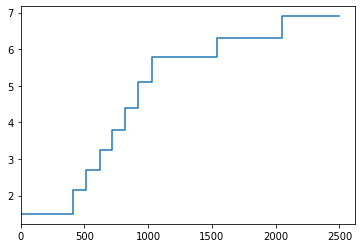

In [319]:
plt.step(p.thresholds + [xmax], p.amounts + [p.amounts[-1]], where='post')
plt.xlim(xmin=0)

Histogramme qui représente les tranches de QF 

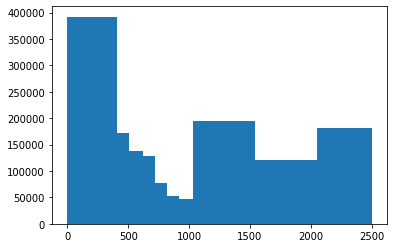

In [322]:
df.CapQF = np.minimum(df.QF, xmax)
res = plt.hist(df.CapQF, bins=p.thresholds + [xmax], weights=df.Nombre)

(array([ 55892.,   3502.,   1699.,   1214.,   5147.,   6920.,   7864.,
          5705.,   5610.,  18575.,  30152.,  33427.,  34074.,  49473.,
         45372.,  63930.,  56191.,  47523.,  43396.,  35414.,  29831.,
         34446.,  27995.,  30565.,  34196.,  31155.,  34382.,  31710.,
         29261.,  20111.,  20053.,  18363.,  17523.,  12783.,  15198.,
         12436.,  10029.,  11626.,  10152.,  11574.,   9695.,   9842.,
          7250.,  11619.,  14240.,   8139.,   8890.,  10324.,  10932.,
         10938.,  10256.,   9325.,   9510.,   9101.,   7296.,   8056.,
          8989.,   8450.,  10778.,   9289.,   9593.,   6834.,   8534.,
          8010.,   6550.,   3814.,   7346.,   6764.,   5375.,   8604.,
          7238.,   5783.,   6308.,   6350.,   5758.,   3647.,   5502.,
          5621.,   5012.,   4610.,   3795.,   3168.,   3552.,   3837.,
          3723.,   4792.,   3278.,   4376.,   3978.,   3187.,   2549.,
          1857.,   1663.,   2300.,   1925.,   1573.,   1299.,   2980.,
      

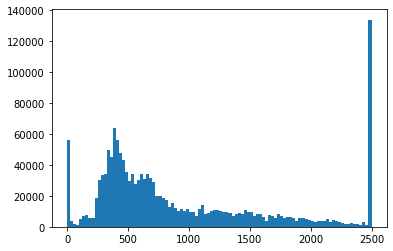

In [321]:
plt.hist(df.CapQF, bins=100, weights=df.Nombre)

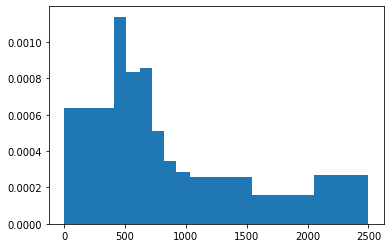

In [323]:
res = plt.hist(df.CapQF, bins=p.thresholds + [xmax], density=True, weights=df.Nombre)

In [324]:
df

,Id Personne,Id Famille,QF,Type repas,Nombre,id gale ou non,type de repas simplifi par tarif identique,Repas
0,1,325,99999,Repas Végétarien,2,NaN,Repas vgtarien,cantine_vegetarien
1,2,497,636,Repas Standard,1,NaN,Repas Standard,cantine
2,3,762,99999,Repas Standard,1,NaN,Repas Standard,cantine
3,4,770,392,Repas Standard,125,oui,Repas Standard,cantine
4,4,770,99999,Repas Standard,1,NaN,Repas Standard,cantine
...,...,...,...,...,...,...,...,...
16930,15579,10849,99999,Repas Sans Porc,8,NaN,Repas Standard,cantine
16931,15580,10850,99999,Repas Standard,13,NaN,Repas Standard,cantine
16932,15581,10851,259,Repas Standard,12,NaN,Repas Standard,cantine
16933,15582,10852,620,Repas Standard,14,NaN,Repas Standard,cantine


(array([ 392203.,  563397.,  701017.,  830038.,  907026.,  958992.,
        1005681., 1201111., 1321568., 1503603.]),
 array([  -1,  410,  510,  620,  720,  820,  920, 1030, 1540, 2050, 2500]),
 <BarContainer object of 10 artists>)

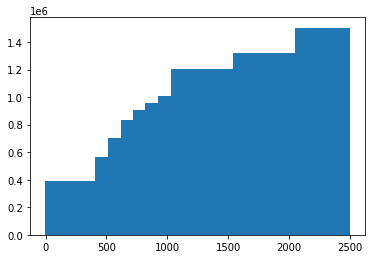

In [325]:
plt.hist(df.CapQF, bins=p.thresholds + [xmax], cumulative=True, weights=df.Nombre)

(array([366299., 183836., 953468.]),
 array([  -1,  400,  500, 2500]),
 <BarContainer object of 3 artists>)

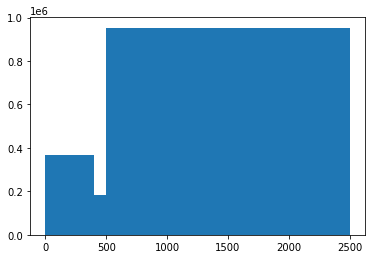

In [326]:
plt.hist(df.CapQF, bins=[-1, 400, 500, xmax], weights=df.Nombre)

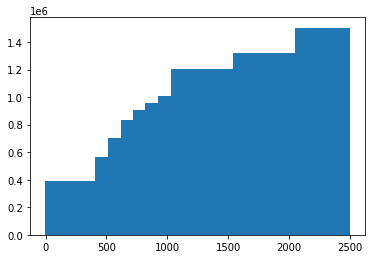

In [327]:
res = plt.hist(df.CapQF, bins=p.thresholds + [xmax], weights=df.Nombre, cumulative=True)